## Load data, balance classes and save

Normalize across *both* time and stations

In [1]:
import sys
sys.path.append("../utils/.")

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# tf.random.set_random_seed(13)

from utils import *
import copy 


In [4]:
data_path = '../data/acc/compressed/full_data.npy'
save_path = "../data/histStat_norm_acc/"

if not os.path.exists(save_path):
    os.makedirs(save_path)

STEP = 1
future_target = 10
past_history = 15


## The Ridgecrest Dataset
This notebook uses a earthquake dataset from Ridgecrest, collected from July to September of 2019.
There are several thousand earthquakes during this time period, which were collected at anywhere from 16-30 stations.

In [11]:
#Swap axes
dataset = np.load(data_path)
print("Before: ", dataset.shape)

dataset = dataset.swapaxes(1, -1)

TRAIN_SPLIT_IDX = int(dataset.shape[0]*0.8)


#Combine station and xyz
#dataset = dataset.reshape(dataset.shape[0], dataset.shape[1], -1)
print("After: ", dataset.shape)

Before:  (35679, 15, 60)
After:  (35679, 60, 15)


In [12]:
dataset.max() 

2.6316105561952106

35679
-0.49 7.1
35679
0.0 3.0
[8.31445749e-01 3.72105878e-01 9.15785421e+00 1.48662500e+03]
[2.000e+00 1.000e+00 1.000e+01 1.488e+03]


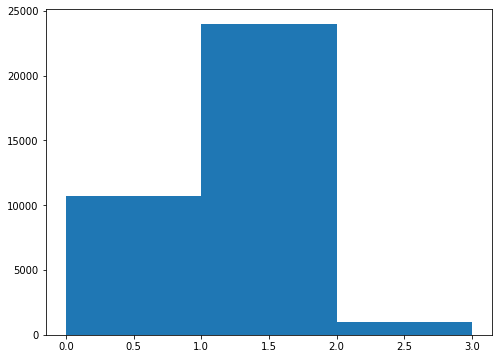

In [13]:
from sklearn.utils.class_weight import compute_class_weight

richters_path = "../data/metadata/richters.npy"
richters = np.load(richters_path)
print(len(richters))
print(min(richters), max(richters))

classes = [0, 1, 2, 3]
richters_discrete = np.zeros_like(richters)
richters_discrete += np.where(richters >= 5., np.ones_like(richters), np.zeros_like(richters))
richters_discrete += np.where(richters >= 3., np.ones_like(richters), np.zeros_like(richters))
richters_discrete += np.where(richters >= 1., np.ones_like(richters), np.zeros_like(richters))

print(len(richters_discrete))
print(min(richters_discrete), max(richters_discrete))


class_weights = compute_class_weight('balanced', np.array(classes), richters_discrete)
print(class_weights)
# num_copies = np.round(class_weights, 0) + 1 #Add constant to ensure minimum num copies for smallest class
num_copies = np.round(class_weights, 0) + 1 #Add constant to ensure minimum num copies for smallest class

print(num_copies)
plt.hist(richters_discrete, bins=[0, 1, 2, 3])
plt.show()

In [14]:
from sklearn.model_selection import train_test_split

dataset, richters_discrete = shuffle_together(dataset, richters_discrete, seed=10)

In [21]:
largest_idxs_train = np.where(richters_discrete[:TRAIN_SPLIT_IDX] == classes[-1])
largest_idxs_val = np.where(richters_discrete[TRAIN_SPLIT_IDX:] == classes[-1])

print(largest_idxs_train, largest_idxs_val)

(array([11660, 13108, 19117, 24685]),) (array([5385, 6250]),)


In [23]:
## Normalization over 60-sec intervals
# dataset dims are (N, T, dim)
data_mean = np.mean(dataset, axis = (1, 2), keepdims=True) #(N, 1, 1)

data_var = np.linalg.norm(dataset - data_mean, axis = (1, 2), keepdims=True) # (N,1,1) 

#Add some epsilon to make the divide by zero var work
data_var[data_var == 0] = 1

dataset_normalized = (dataset - data_mean)/data_var #(N, T, dim)

x_train_norm, y_train_norm = multivariate_data_balanced(dataset_normalized[:TRAIN_SPLIT_IDX],past_history,
                                                   future_target, STEP,
                                               richters_discrete[:TRAIN_SPLIT_IDX], num_copies,
                                                   single_step=False)
x_val_norm, y_val_norm = multivariate_data(dataset_normalized[TRAIN_SPLIT_IDX:], past_history,
                                               future_target, STEP,
                                               single_step=False)

print([(tensor.max(), tensor.min()) for tensor in [x_train_norm, y_train_norm, x_val_norm, y_val_norm]])


np.save(os.path.join(save_path, "X_train_norm60.npy"), x_train_norm)
np.save(os.path.join(save_path, "y_train_norm60.npy"), y_train_norm)
np.save(os.path.join(save_path, "X_val_norm60.npy"), x_val_norm)
np.save(os.path.join(save_path, "y_val_norm60.npy"), y_val_norm)

[(0.9613582287103106, -0.049161971351137305), (0.9638939532466916, -0.049161971351137305), (0.946945358178671, -0.04031726959350601), (0.946945358178671, -0.04031726959350601)]


In [30]:
## Save Richter 5-7 earthquakes FROM VAL SET

large_tensors = dataset[TRAIN_SPLIT_IDX:][largest_idxs_val]

x_val_norm_large, y_val_norm_large = multivariate_data(large_tensors, past_history,
                                               future_target, STEP,
                                               single_step=False)

print(x_val_norm_large.max(), x_val_norm_large.min())
np.save(os.path.join(save_path, "large_X_val_norm.npy"), x_val_norm_large)
np.save(os.path.join(save_path, "large_y_val_norm.npy"), y_val_norm_large)
print(len(x_val_norm_large))

2.6316105561952106 5.55771493088387e-06
70


In [9]:
train_distrib = list([int(np.sum(richters_discrete[:TRAIN_SPLIT_IDX] == i)) for i in range(4)])
val_distrib = list([int(np.sum(richters_discrete[TRAIN_SPLIT_IDX:] == i)) for i in range(4)])
print("Distribution of discrete richter magnitudes (<1, 1-3, 3-5, >=5):")
print("Train set: ", train_distrib)
print("Val set: ", val_distrib)


Distribution of discrete richter magnitudes (<1, 1-3, 3-5, >=5):
Train set:  [8560, 19193, 786, 4]
Val set:  [2168, 4778, 188, 2]


In [10]:
x_train_single, y_train_single = multivariate_data_balanced(dataset[:TRAIN_SPLIT_IDX],past_history,
                                                   future_target, STEP,
                                               richters_discrete[:TRAIN_SPLIT_IDX], num_copies,
                                                   single_step=False)
x_val_single, y_val_single = multivariate_data(dataset[TRAIN_SPLIT_IDX:], past_history,
                                               future_target, STEP,
                                               single_step=False)


# print(y_single.shape, x_single.shape)
# x_train_single, x_val_single, y_train_single, y_val_single = train_test_split(x_single, y_single, test_size=.2, random_state=13)
print(x_train_single.shape, x_val_single.shape, y_train_single.shape, y_val_single.shape)

(1754375, 15, 15) (249760, 15, 15) (1754375, 10, 15) (249760, 10, 15)


In [11]:
print(x_train_single.min(), x_train_single.max())
print(y_train_single.min(), y_train_single.max())

print(x_val_single.min(), x_val_single.max())
print(y_val_single.min(), y_val_single.max())

0.0 0.937006525584025
0.0 0.937006525584025
0.0 2.6316105561952106
0.0 2.6316105561952106


In [12]:
np.save(os.path.join(save_path, "X_train_unnorm.npy"), x_train_single)
np.save(os.path.join(save_path, "y_train_unnorm.npy"), y_train_single)
np.save(os.path.join(save_path, "X_val_unnorm.npy"), x_val_single)
np.save(os.path.join(save_path, "y_val_unnorm.npy"), y_val_single)

# Normalization over 15-sec history

In [13]:
"""
Effect of different eps values
"""

train_means, train_vars = [], []
val_means, val_vars = [], []

for i in range(1, 15):
    eps = 10**(-i)
    x_train_single_clone = copy.deepcopy(x_train_single)
    x_val_single_clone = copy.deepcopy(x_val_single)
    y_train_single_clone = copy.deepcopy(y_train_single)
    y_val_single_clone = copy.deepcopy(y_val_single)

    data_mean_train = np.mean(x_train_single_clone, axis = 1, keepdims=True)

    # print(data_mean_train.max(), data_mean_train.min())
    data_var_train = np.linalg.norm(x_train_single_clone - data_mean_train, axis=1, keepdims=True)
    data_var_train[data_var_train < eps] = 1

    # print(data_var_train.max(), data_var_train.min())
    x_train_single_clone = (x_train_single_clone - data_mean_train)/data_var_train
    y_train_single_clone = (y_train_single_clone - data_mean_train)/data_var_train


    data_mean_val = np.mean(x_val_single_clone, axis = 1, keepdims=True)
    data_var_val = np.linalg.norm(x_val_single_clone - data_mean_val, axis=1, keepdims=True)
    data_var_val[data_var_val < eps] = 1

    x_val_single_clone = (x_val_single_clone - data_mean_val)/data_var_val
    y_val_single_clone = (y_val_single_clone - data_mean_val)/data_var_val
    
    train_means.append(x_train_single_clone.mean())
    train_vars.append(x_train_single_clone.std()**2)
    val_means.append(x_val_single_clone.mean())
    val_vars.append(x_val_single_clone.std()**2)

KeyboardInterrupt: 

In [ ]:
plt.plot([i for i in range(1, 15)], train_means)
plt.plot([i for i in range(1, 15)], val_means)
plt.title("Means")
plt.show()

plt.plot([i for i in range(1, 15)], train_vars)
plt.plot([i for i in range(1, 15)], val_vars)
plt.title("Vars")
plt.show()

In [14]:
eps = 1e-7
"""
Normalizing using 15-sec history across TIME and STATIONS
"""
# for i in range(x_train_single.shape[0]):
data_mean_train = np.mean(x_train_single, axis = (1, 2), keepdims=True)

# print(data_mean_train.max(), data_mean_train.min())
data_var_train = np.linalg.norm(x_train_single - data_mean_train, axis=(1, 2), keepdims=True)
data_var_train[data_var_train < eps] = 1

# print(data_var_train.max(), data_var_train.min())
x_train_single = (x_train_single - data_mean_train)/data_var_train
y_train_single = (y_train_single - data_mean_train)/data_var_train


data_mean_val = np.mean(x_val_single, axis = (1, 2), keepdims=True)
data_var_val = np.linalg.norm(x_val_single - data_mean_val, axis=(1,2), keepdims=True)
data_var_val[data_var_val < eps] = 1

x_val_single = (x_val_single - data_mean_val)/data_var_val
y_val_single = (y_val_single - data_mean_val)/data_var_val

In [15]:
print(y_val_single.max(), y_train_single.max())

8406.308890708404 2914.7723996078616


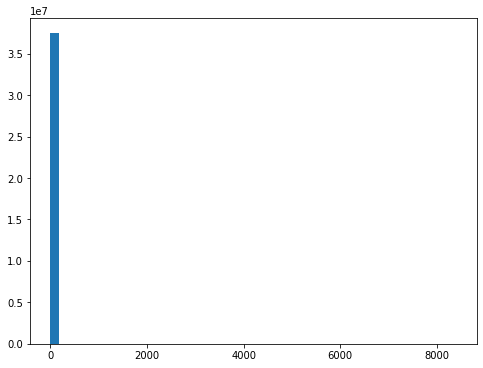

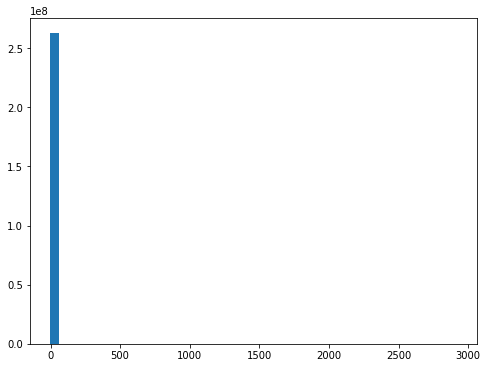

In [16]:
plt.hist(y_val_single.flatten(), bins=50)
plt.show()

plt.hist(y_train_single.flatten(), bins=50)
plt.show()

In [17]:
print(sum(y_val_single.flatten() > 10) / len(y_val_single.flatten()))

0.00031077834721332477


In [18]:
print(x_train_single.max(), x_train_single.min())
print(x_val_single.max(), x_val_single.min())

0.9977698130146953 -0.11858546177948899
0.9977431495494686 -0.11782828706996022


In [19]:
print(y_train_single.max(), y_train_single.min())
print(y_val_single.max(), y_val_single.min())

2914.7723996078616 -0.11858409248741932
8406.308890708404 -0.11782828706996021


In [20]:
x_train_single.shape, y_train_single.shape, x_val_single.shape, y_val_single.shape

((1754375, 15, 15), (1754375, 10, 15), (249760, 15, 15), (249760, 10, 15))

In [21]:
np.save(os.path.join(save_path, "X_train_histnorm.npy"), x_train_single)
np.save(os.path.join(save_path, "y_train_histnorm.npy"), y_train_single)
np.save(os.path.join(save_path, "X_val_histnorm.npy"), x_val_single)
np.save(os.path.join(save_path, "y_val_histnorm.npy"), y_val_single)

np.save(os.path.join(save_path, "richters_discrete.npy"), richters_discrete)

np.save(os.path.join(save_path, "mean_train_histnorm.npy"), data_mean_train)
np.save(os.path.join(save_path, "var_train_histnorm.npy"), data_var_train)
np.save(os.path.join(save_path, "mean_val_histnorm.npy"), data_mean_val)
np.save(os.path.join(save_path, "var_val_histnorm.npy"), data_var_val)

In [22]:
import json

config = dict(zip(["data_path", "past_history", "STEP", "future_target", "train_distrib", "val_distrib", ], \
                  [data_path, past_history, STEP, future_target, train_distrib, val_distrib]))

with open(os.path.join(save_path, "config.json"), 'w') as json_file:
    json.dump(config, json_file)

In [ ]:
print(x_train_single.max())